In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sns
import h5py
import DCCSMLM

%matplotlib notebook

In [4]:
mVenus_filename = "ExampleData/20190429_8b_cam1_sml.mat"
mCherry_filename = "ExampleData/20190429_8c_cam1_sml.mat"

raw_data = DCCSMLM.DCCSMLM()
raw_data.load_channel(mVenus_filename, channel_id=0)
raw_data.load_channel(mCherry_filename, channel_id=1, ca_file="ExampleData/CA_parameters.csv")


In [5]:
raw_data.channel["0"]

<IPython.core.display.Javascript object>


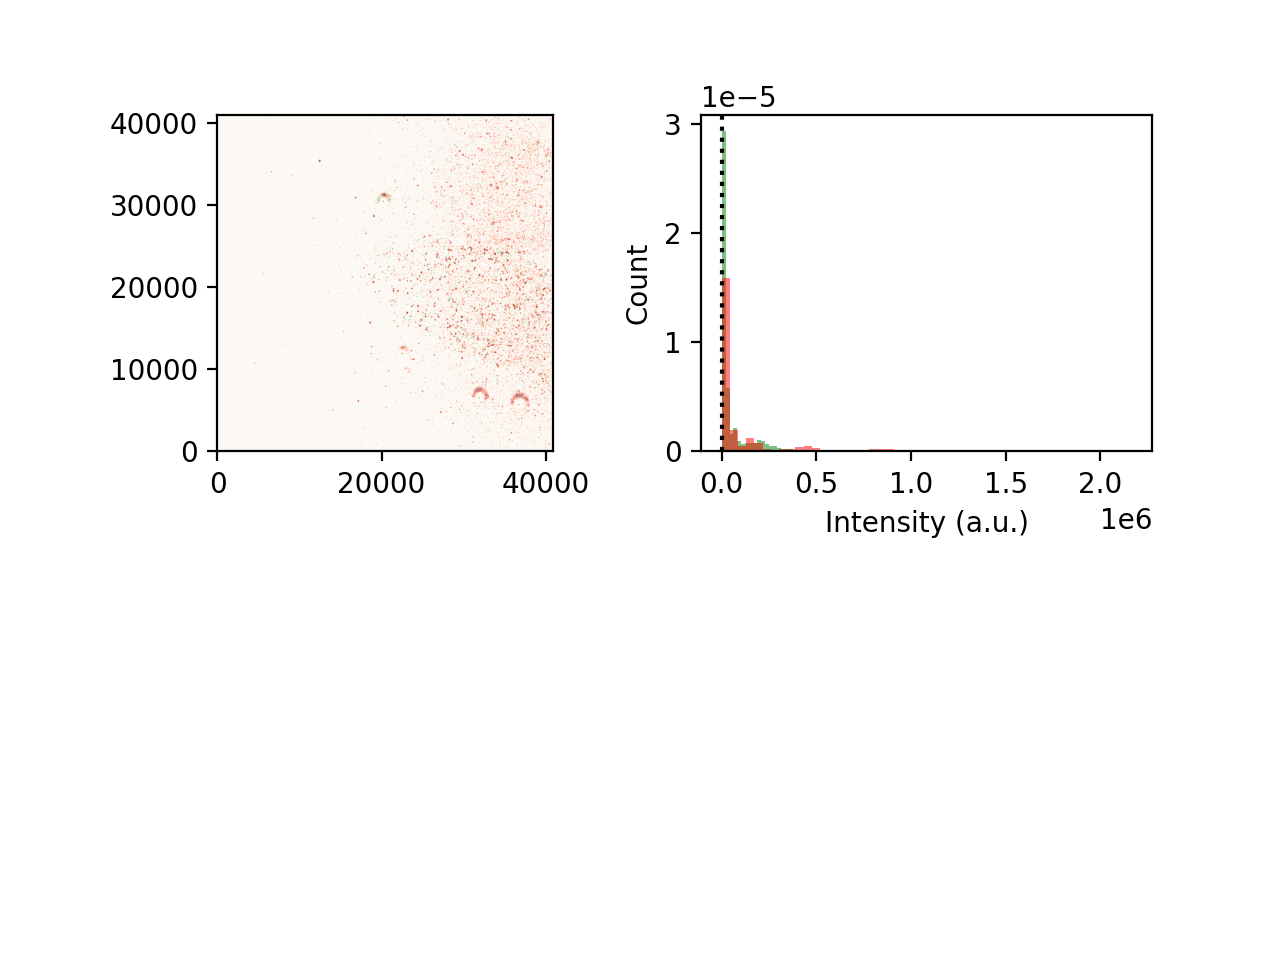

In [6]:
plt.subplot(221)
imgplot = plt.imshow(raw_data.channel["0"].generate_reconstruction(), cmap="Greens", alpha=0.5, extent=[0,40960,0,40960])
imgplot = plt.imshow(raw_data.channel["1"].generate_reconstruction(), cmap="Reds", alpha=0.5, extent=[0,40960,0,40960])



plt.subplot(222)
plt.hist(raw_data.channel["0"].raw_data[raw_data.channel["0"].intensity_column],
         color="green", alpha=0.5, bins=50, density=True)
plt.hist(raw_data.channel["1"].raw_data[raw_data.channel["0"].intensity_column],
         color="red", alpha=0.5, bins=50, density=True)
plt.axvline(100, color="black", ls=":")
plt.xlabel("Intensity (a.u.)")
plt.ylabel("Count")

plt.show()

In [7]:
# Find the fiducial markers based on an intensity_threshold, min_samples and eps
a = raw_data.channel["0"].find_clusters(intensity_threshold=10_000, min_samples=500, eps=100) 

b = raw_data.channel["1"].find_clusters(intensity_threshold=10_000, min_samples=500, eps=100) 




<IPython.core.display.Javascript object>


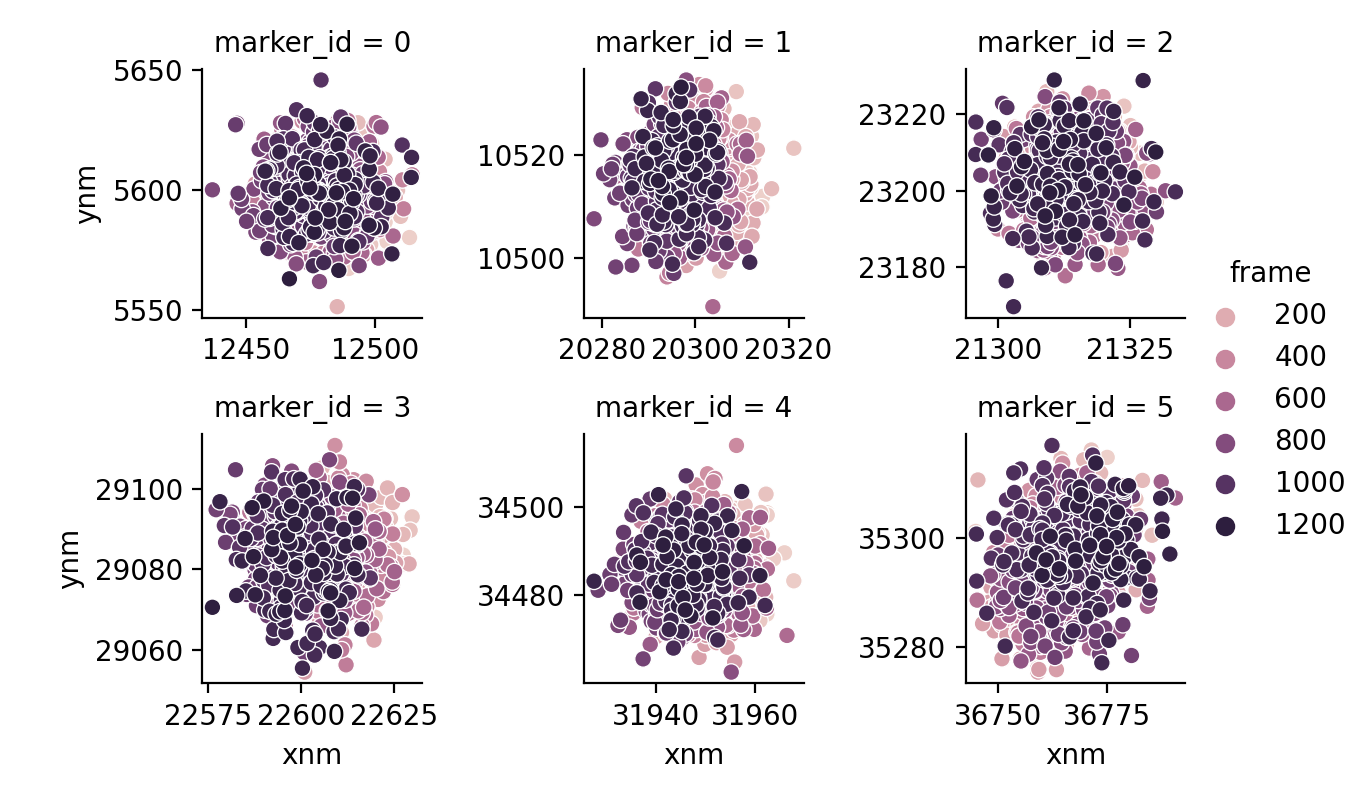

<IPython.core.display.Javascript object>


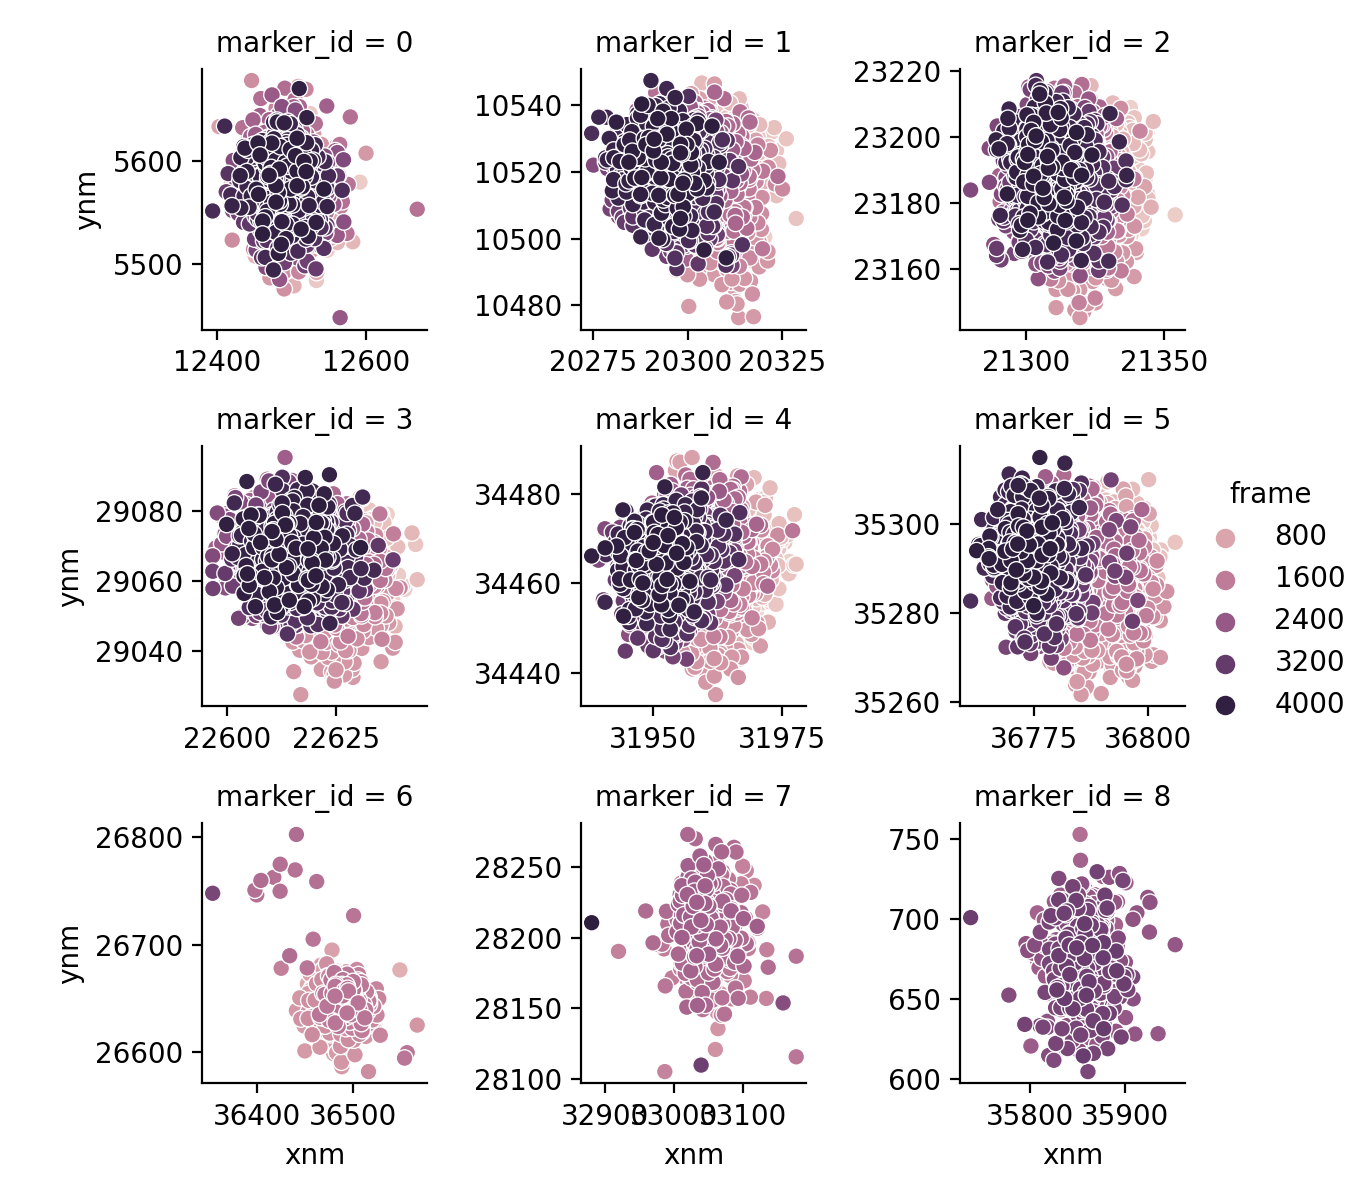

In [8]:
# Show the coordinates of all identified markers
sns.relplot(data=a[a.marker_id>=0], x="xnm", y="ynm", hue="frame", col="marker_id", col_wrap=3, height=2,
            facet_kws={'sharey': False, 'sharex': False})

# Show the coordinates of all identified markers
sns.relplot(data=b[b.marker_id>=0], x="xnm", y="ynm", hue="frame", col="marker_id", col_wrap=3, height=2,
            facet_kws={'sharey': False, 'sharex': False})

<IPython.core.display.Javascript object>


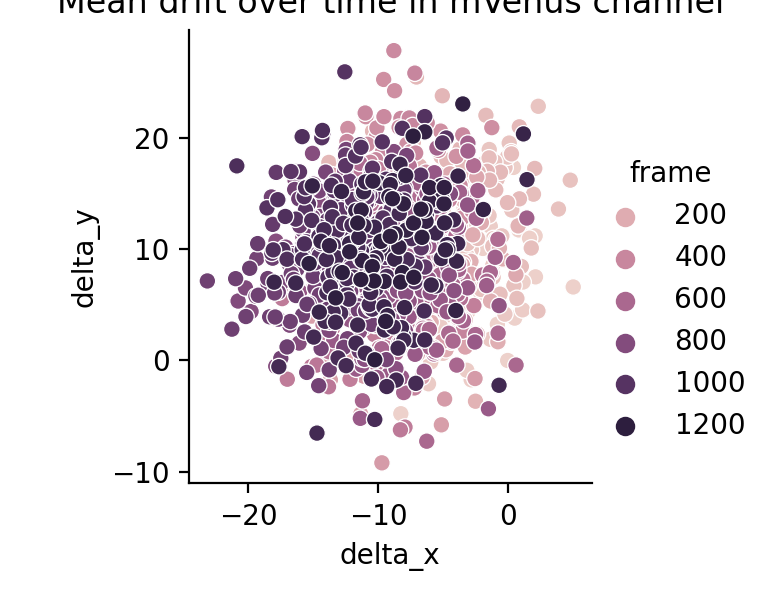

<IPython.core.display.Javascript object>


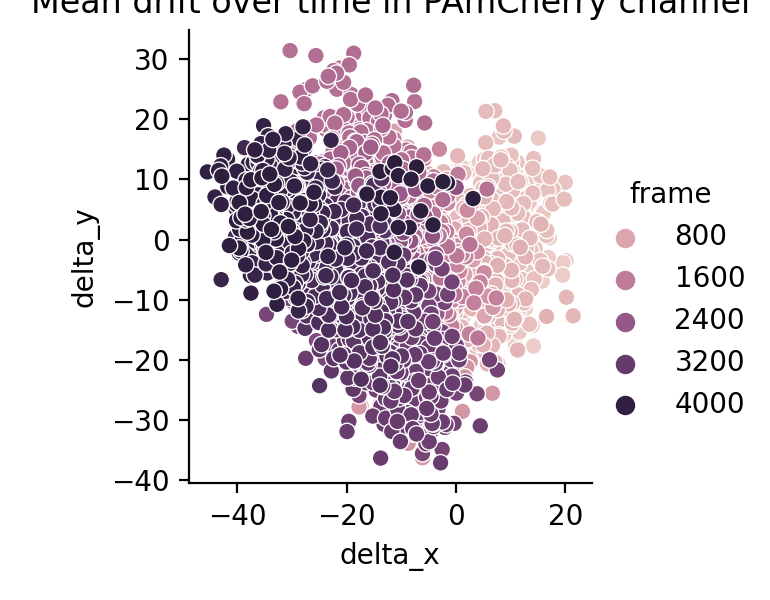

In [9]:
## Correct mVenus channel

ignore_marker = [-1] # Ignore these marker IDs for drift correction

# Extract the trajectories for all IDs except for those in ignore_marker
id_list = list(a.marker_id.unique()[np.isin(a.marker_id.unique(), ignore_marker, invert=True)])

# Extract the trajectories, the mean is also saved in the drift variable of the channel
raw_data.channel["0"].extract_drift(a, "marker_id", id_list=id_list)

# Plot the mean trajectory
g = sns.relplot(data = raw_data.channel["0"].drift, x="delta_x", y="delta_y", kind="scatter", 
            hue="frame", height=3)
plt.title("Mean drift over time in mVenus channel")
plt.show()

## Correct PAmCherry channel

ignore_marker = [-1] # Ignore these marker IDs for drift correction

# Extract the trajectories for all IDs except for those in ignore_marker
id_list = list(b.marker_id.unique()[np.isin(b.marker_id.unique(), ignore_marker, invert=True)])

# Extract the trajectories, the mean is also saved in the drift variable of the channel
raw_data.channel["1"].extract_drift(b, "marker_id", id_list=id_list)

# Plot the mean trajectory
g = sns.relplot(data = raw_data.channel["1"].drift, x="delta_x", y="delta_y", kind="scatter", 
            hue="frame", height=3)
plt.title("Mean drift over time in PAmCherry channel")
plt.show()




In [11]:
raw_data.channel["0"].correct_drift()
raw_data.channel["1"].correct_drift()



In [12]:
for channel in raw_data.channel:
    print(f"Looking for clusters in channel {channel}")
    # Find all protein clusters in the channels
    raw_data.channel[channel].find_clusters(intensity_threshold=100, min_samples=3, eps=100, save_column="clusters") 



Looking for clusters in channel 0
Looking for clusters in channel 1


<IPython.core.display.Javascript object>


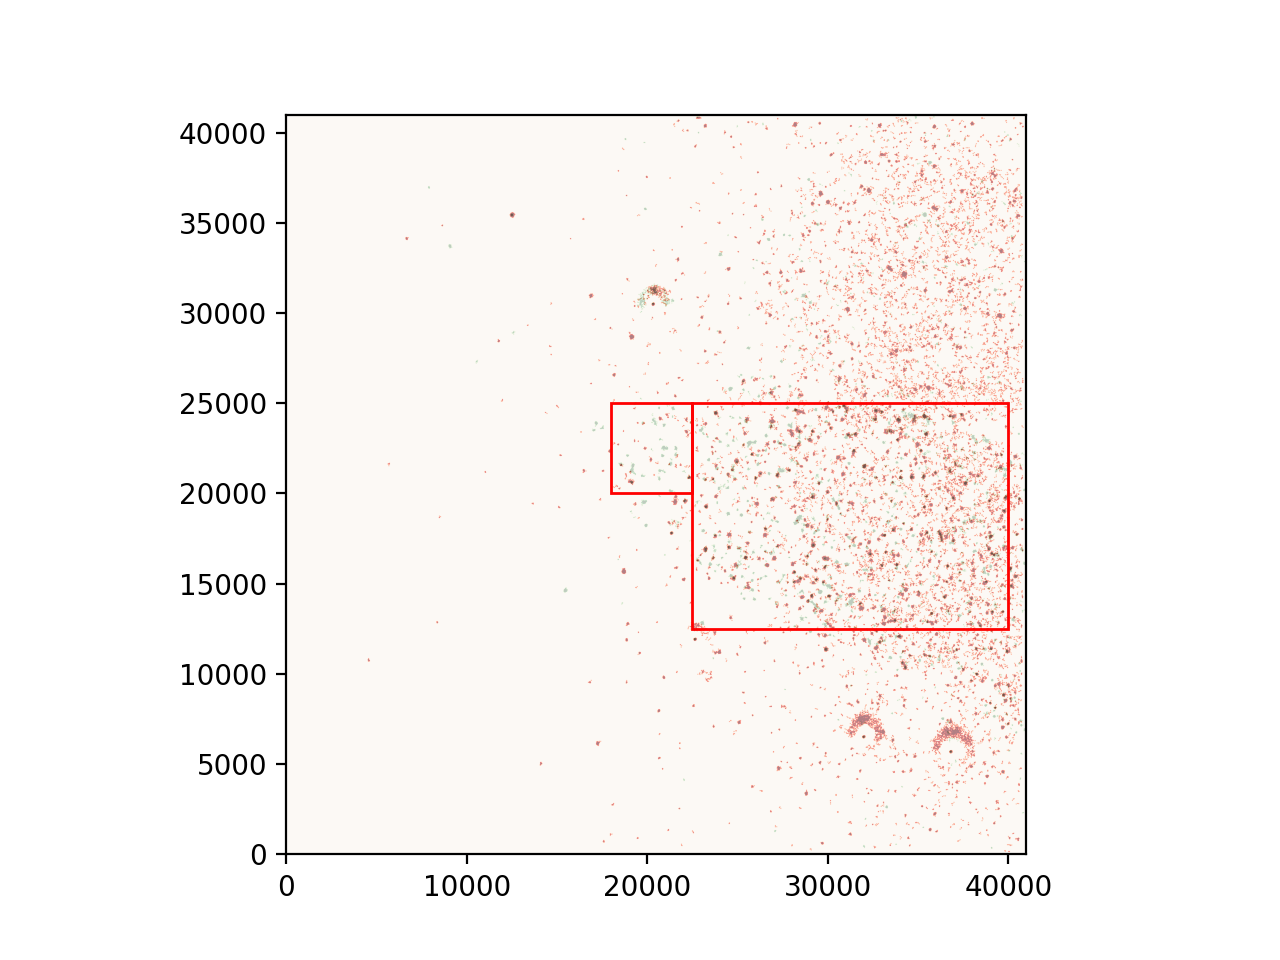

In [13]:
# Display drift corrected image

rois = [(22500, 12500, 17500, 12500), 
        (18000, 20000, 4500, 5000)]

plt.figure()
imgplot = plt.imshow(raw_data.channel["0"].generate_reconstruction(cluster_column="clusters"), cmap="Greens", 
                     alpha=0.5, extent=[0,40960,0,40960])
imgplot = plt.imshow(raw_data.channel["1"].generate_reconstruction(cluster_column="clusters"), cmap="Reds", 
                     alpha=0.5, extent=[0,40960,0,40960])

# draw rois on top of the image
for roi in rois:
    rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.show()




In [14]:
coloc_ratio = raw_data.get_colocalization_ratio("0", "1", "clusters", distance_cutoff=100, rois=rois)
print(f"The colocalization ratio within the ROIs is {round(coloc_ratio, 5)}")

The colocalization ratio within the rois is 0.28535
